In [1]:
using Oceananigans
using CairoMakie
using JLD2
using Statistics

[ Info: Oceananigans will use 4 threads


In [32]:
foldername = "../../../scratch/filament-instability/supplementary/Ri010-3d"
filename = "3d_state.jld2"
paramfilename = "parameters.jld2"
sp = jldopen("$foldername/$paramfilename") do file
    file["parameters/simulation"]
end
frames, grid = jldopen("$foldername/$filename") do file
    (keys(file["timeseries/t"])[1:end], file["serialized/grid"])
end
ts = jldopen("$foldername/$filename") do file
    [file["timeseries/t/$frame"] for frame in frames] .- 1
end
xᶜᵃᵃ = xnodes(grid, Center())
xᶠᵃᵃ = xnodes(grid, Face())
yᵃᶜᵃ = ynodes(grid, Center())
yᵃᶠᵃ = ynodes(grid, Face())
zᵃᵃᶜ = znodes(grid, Center())
zᵃᵃᶠ = znodes(grid, Face())
Δzᵃᵃᶜ = reshape(diff(zᵃᵃᶠ), 1, 1, length(zᵃᵃᶜ))
Δx = xᶠᵃᵃ[2] - xᶠᵃᵃ[1]
Δy = yᵃᶠᵃ[2] - yᵃᶠᵃ[1]

@inline function dx(fᶜᵃᵃ)
    return (circshift(fᶜᵃᵃ, (-1, 0, 0)) - circshift(fᶜᵃᵃ, (1, 0, 0))) / (2Δx)
end
@inline function dy(fᵃᶜᵃ)
    return (circshift(fᵃᶜᵃ, (0, -1, 0)) - circshift(fᵃᶜᵃ, (0, -1, 0))) / (2Δy)
end
@inline function dz(fᵃᵃᶜ)
    let a = (circshift(fᵃᵃᶜ, (0, 0, -1)) - circshift(fᵃᵃᶜ, (0, 0, 1))) ./ (2Δzᵃᵃᶜ)
        a[:, :, 1] .= 0
        a[:, :, end] .= 0
        a
    end
end

dz (generic function with 1 method)

In [27]:
t = 2.72
i = argmin(abs.(ts .- t))
frame = frames[i]

"3163"

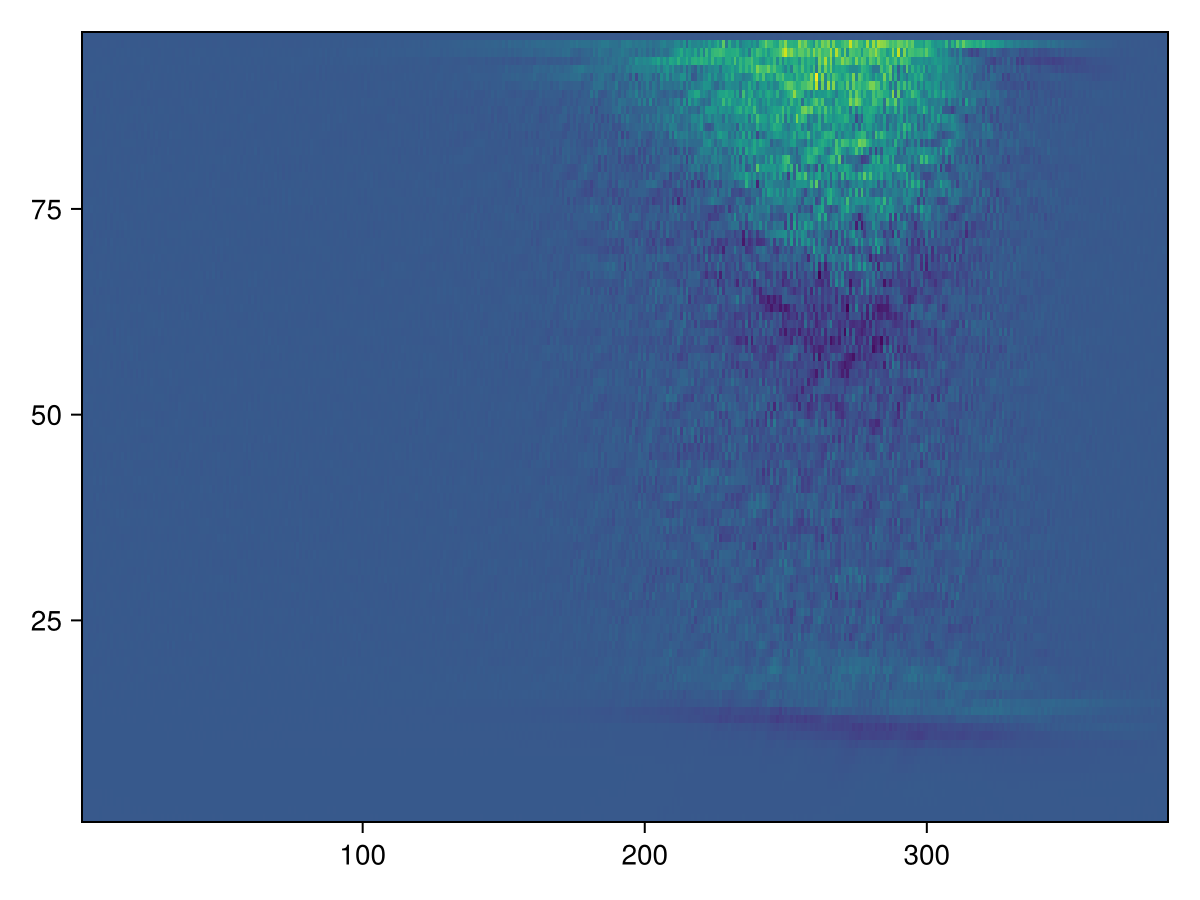

In [28]:
ω = jldopen("$foldername/$filename") do file
    u = file["timeseries/u/$frame"]
    u = (circshift(u, (-1, 0, 0)) .+ circshift(u, (1, 0, 0))) / 2
    w = file["timeseries/w/$frame"]
    w = (w[:, :, 1:end-1] .+ w[:, :, 2:end]) / 2
    ω = dz(u) - dx(w)
    ω[128:512, :, 33:end]
    end;
heatmap(mean(ω; dims=2)[:, 1, :])

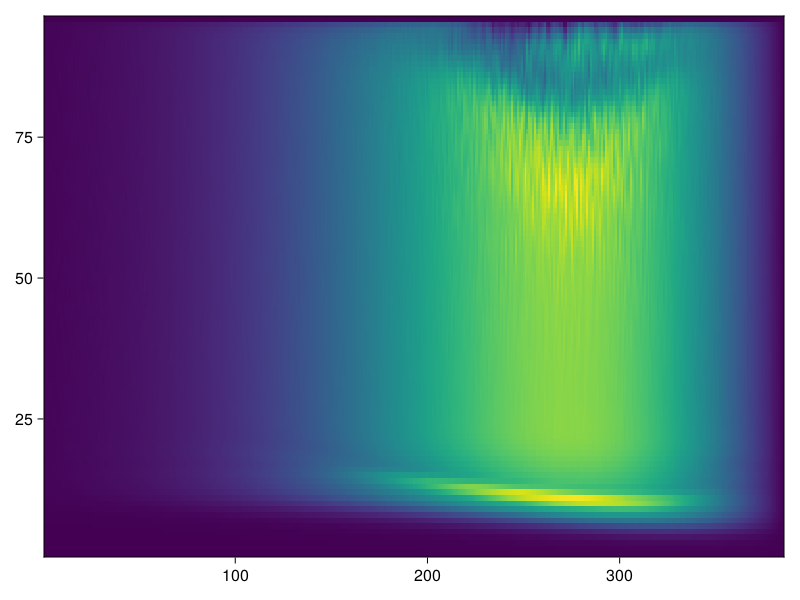

In [61]:
η = jldopen("$foldername/$filename") do file
    v = file["timeseries/v/$frame"]
    v = (circshift(v, (0, -1, 0)) .+ circshift(v, (0, 1, 0))) / 2
    w = file["timeseries/w/$frame"]
    w = (w[:, :, 1:end-1] .+ w[:, :, 2:end]) / 2
    η = dy(w) - dz(v)
    η[128:512, :, 33:end]
    end;
heatmap(mean(η; dims=2)[:, 1, :])

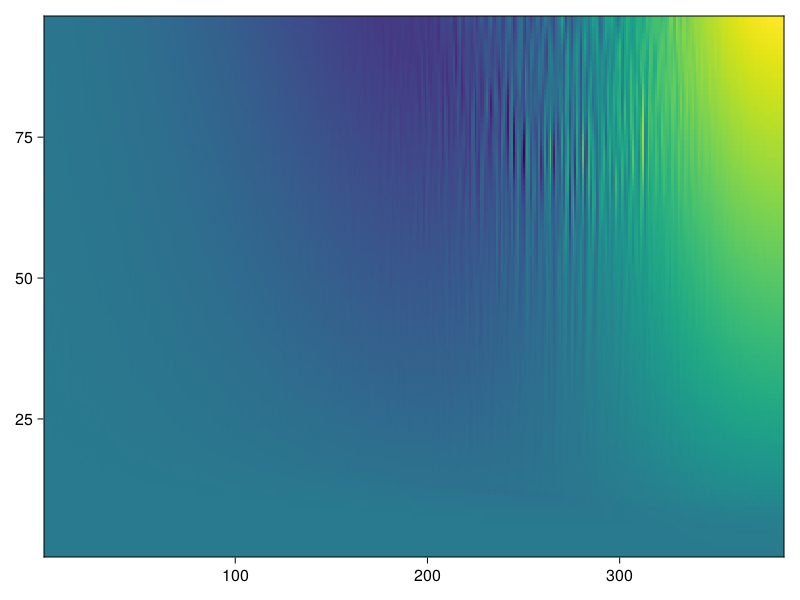

In [62]:
ζ = jldopen("$foldername/$filename") do file
    u = file["timeseries/u/$frame"]
    u = (circshift(u, (-1, 0, 0)) .+ circshift(u, (1, 0, 0))) / 2
    v = file["timeseries/v/$frame"]
    v = (circshift(v, (0, -1, 0)) .+ circshift(v, (0, 1, 0))) / 2
    ζ = dx(v) - dy(u)
    ζ[128:512, :, 33:end]
    end;
heatmap(mean(ζ; dims=2)[:, 1, :])

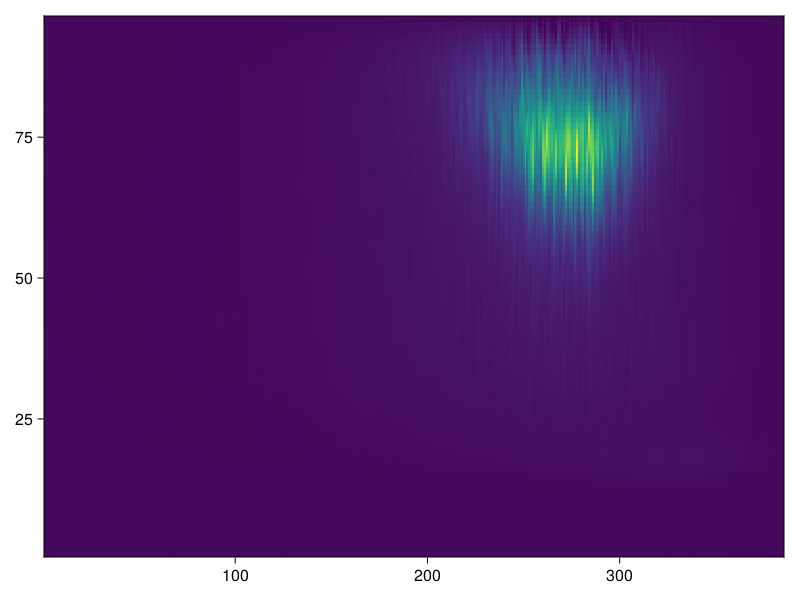

In [63]:
v′w′ = jldopen("$foldername/$filename") do file
    v = file["timeseries/v/$frame"]
    v = (circshift(v, (0, -1, 0)) .+ circshift(v, (0, 1, 0))) / 2
    w = file["timeseries/w/$frame"]
    w = (w[:, :, 1:end-1] .+ w[:, :, 2:end]) / 2
    
    v′ = v .- mean(w; dims=2)
    w′ = w .- mean(w; dims=2)
    
    v′w′ = v′ .* w′
    v′w′[128:512, :, 33:end]
    end;
heatmap(mean(v′w′; dims=2)[:, 1, :])

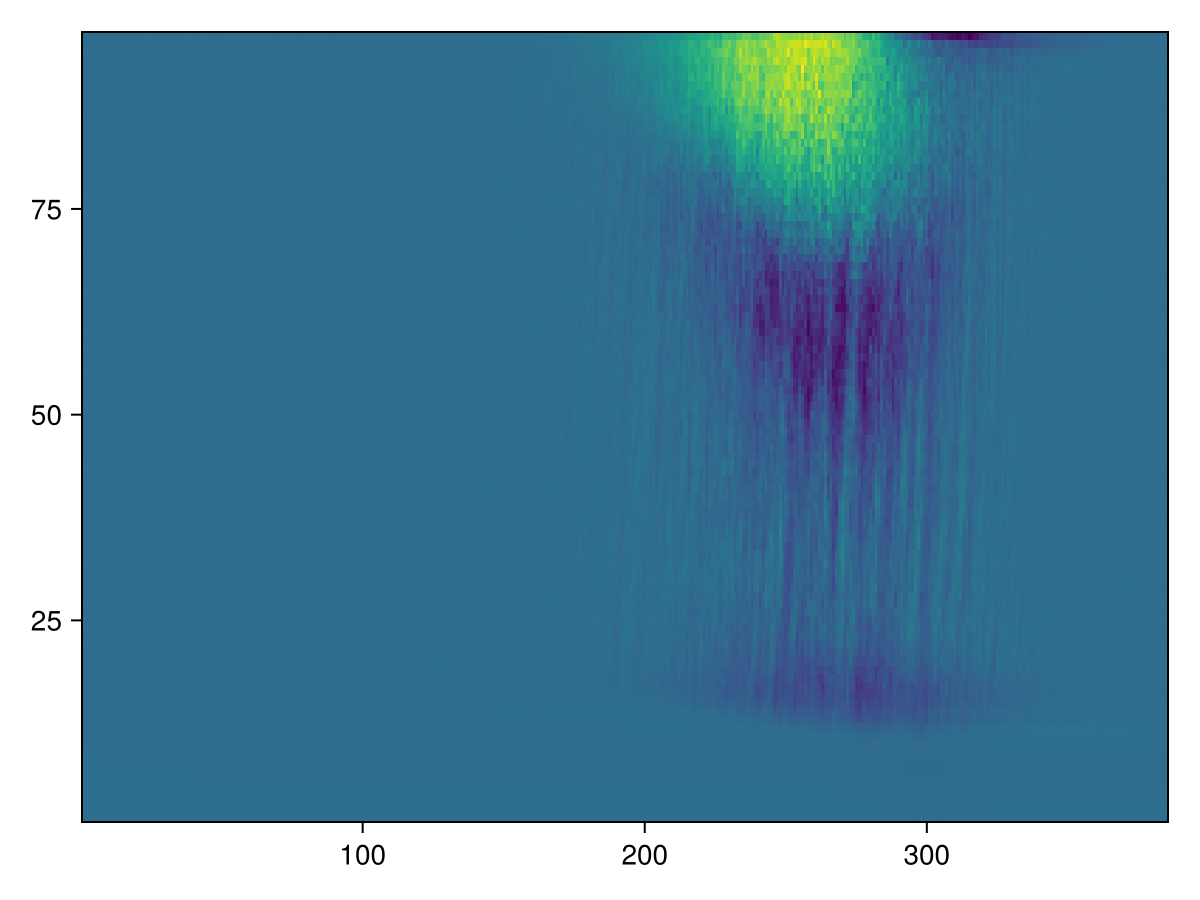

In [29]:
Δv = jldopen("$foldername/$filename") do file
    v = file["timeseries/v/$frame"] .- file["timeseries/v/$(frames[3])"]
    v = (circshift(v, (0, -1, 0)) .+ circshift(v, (0, 1, 0))) / 2
    v[128:512, :, 33:end]
    end;
heatmap(mean(Δv; dims=2)[:, 1, :])

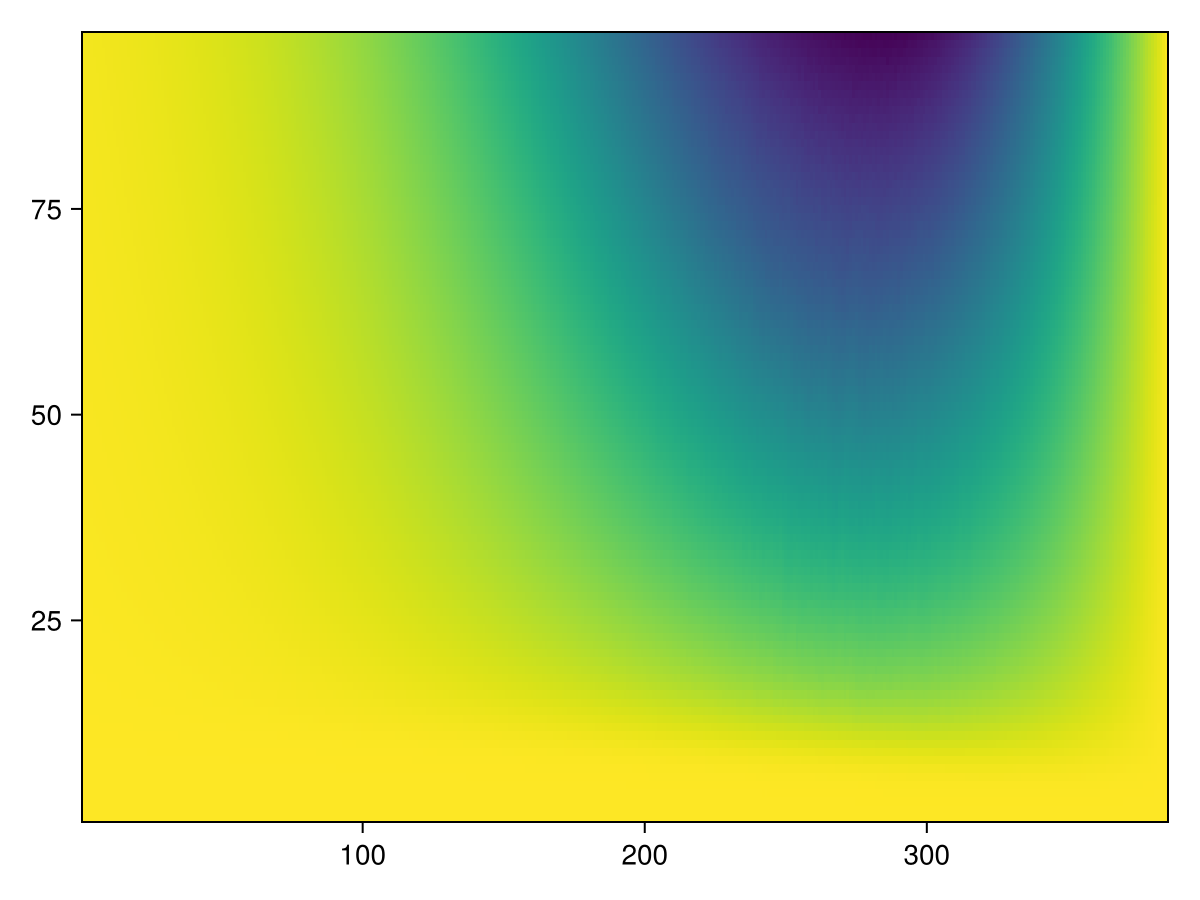

In [30]:
v = jldopen("$foldername/$filename") do file
    v = file["timeseries/v/$frame"]
    v = (circshift(v, (0, -1, 0)) .+ circshift(v, (0, 1, 0))) / 2
    v[128:512, :, 33:end]
    end;
heatmap(mean(v; dims=2)[:, 1, :])

In [31]:
jldopen("../3D-Ri010-$frame.jld2", "a+") do file
    file["ω"] = ω
    #file["η"] = η
    #file["ζ"] = ζ
    #file["v′w′"] = v′w′
    file["v"] = v
    file["Δv"] = Δv
    file["x"] = xᶜᵃᵃ[128:512]
    file["y"] = ynodes(grid, Center())
    file["z"] = zᵃᵃᶜ[33:end]
    file["t"] = t
    end;

In [34]:
field_xz = zeros(length(frames), length(xᶜᵃᵃ), length(zᵃᵃᶜ))
field_xy = zeros(length(frames), length(xᶜᵃᵃ), length(yᵃᶜᵃ))
field_yz = zeros(length(frames), length(yᵃᶜᵃ), length(zᵃᵃᶜ))
for (i, frame) in enumerate(frames)
    jldopen("$foldername/$filename") do file
        field = file["timeseries/v/$frame"]
        field = (circshift(field, (0, -1, 0)) .+ circshift(field, (0, 1, 0))) / 2
        field_xz[i, :, :] .= field[:, 1, :]
        field_xy[i, :, :] .= field[:, :, end]
        field_yz[i, :, :] .= field[end, :, :]
    end
end
jldopen("../volume_video_Ri010.jld2", "a+") do file
    file["v_xz"] = field_xz
    file["v_xy"] = field_xy
    file["v_yz"] = field_yz
    #file["xs"] = xᶜᵃᵃ
    #file["ys"] = yᵃᶜᵃ
    #file["zs"] = zᵃᵃᶜ
    #file["ts"] = ts
    end;